# Random Forests 3

---

This notebook evaluates the results of the previous random forest grid searches on the 12 representations.

The purpose is to narrow down on a representation and couple models to tweak in a final and more robust GridSearchCV. 

*Previous Results*

- Cosine similarity models perform better overall (best accuracies and sensitivities)
- `mtry=None` is too time consumng for the small gains it might provide
- for the small differences in top sensitivities, `Cossim on Tfidf, mtry=50` (and `mtry=100,250`) have the best time

## Setup & Load CV results

In [1]:
import os
import time
import json
import joblib 

import numpy as np
import pandas as pd

from datetime import datetime

dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

dir_path = os.path.join("data","3_modeling")
file_path = os.path.join(dir_path, "01052021_rf_gridsearches.joblib")
gridsearches = joblib.load(file_path)

Revised on: 2021-01-05


In [61]:
def extract_df(dic):
    df = pd.concat([
                    pd.DataFrame({'representation':[dic['representation']] \
                                * len(dic['gridsearch_res'].cv_results_["params"])}),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["params"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_acc"], 
                                 columns=["mean_val_acc"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tpr"], 
                                 columns=["mean_val_tpr"]),
                    pd.DataFrame(dic['gridsearch_res'].cv_results_["mean_test_tnr"], 
                                 columns=["mean_val_tnr"])
                    ], axis=1)
    return df

In [63]:
# create list of dfs
df_list = []
for ix, dic in enumerate(gridsearches):
    df_list.append(extract_df(dic))

# flatten and reindex
dfm = pd.concat(df_list)
dfm.index = range(len(dfm))
dfm.head()

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
0,X_bot_feat,5,50,5,100,0.941200,0.556950,1.0
1,X_bot_feat,5,50,5,200,0.941541,0.559312,1.0
2,X_bot_feat,5,50,10,100,0.941541,0.559447,1.0
3,X_bot_feat,5,50,10,200,0.941199,0.556748,1.0
4,X_bot_feat,5,50,15,100,0.941541,0.559447,1.0


## Top mean validation sensitivity

In [64]:
# sort by validation sensitivity
top_tpr = dfm.sort_values(by=['mean_val_tpr'], ascending=False).iloc[:10,:].copy()
top_tpr

,representation,max_depth,max_features,min_samples_split,n_estimators,mean_val_acc,mean_val_tpr,mean_val_tnr
68,X_bot_feat,20,500,10,100,0.980508,0.886640,0.994876
67,X_bot_feat,20,500,5,200,0.981194,0.884143,0.996060
66,X_bot_feat,20,500,5,100,0.981194,0.884076,0.996060
70,X_bot_feat,20,500,15,100,0.979825,0.881511,0.994876
69,X_bot_feat,20,500,10,200,0.980509,0.881511,0.995665
61,X_bot_feat,20,250,5,200,0.982220,0.878947,0.998028
60,X_bot_feat,20,250,5,100,0.981876,0.878880,0.997635
71,X_bot_feat,20,500,15,200,0.979824,0.876316,0.995665
65,X_bot_feat,20,250,15,200,0.981535,0.873684,0.998028
64,X_bot_feat,20,250,15,100,0.980165,0.873617,0.996452


In [81]:
# concatenate representation and n_estimators for plt.xlabel
top_tpr['xticks'] = top_tpr.agg(lambda x: \
f"{x['representation']}-{x['n_estimators']}-{x['max_depth']}-{x['max_features']}-{x['min_samples_split']}", axis=1)

In [66]:
# normalize seconds to fit in one plot
#def normalize(X):
#    norm = np.zeros([len(X)])
#    for i in range(len(X)):
#        norm[i] = (X[i] - min(X)) / (max(X)-min(X))
#    return norm
#
#top_accs['elapsed_norm'] = normalize(np.array(top_accs['elapsed_seconds']))
#top_accs

In [98]:
import matplotlib.pyplot as plt
from matplotlib import transforms 

# first of all, the base transformation of the data points is needed

# define transformed line
#line = pyplot.plot(data, 'r--', transform= rot + base)

def plot_topscores(X):
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(90)
    plt.figure(figsize=(14, 8))
    plt.plot(np.array(X['mean_val_acc']), label="mean validation accuracy", transform= rot + base)
    plt.plot(np.array(X['mean_val_tpr']), label="mean validation sensitivity", transform= rot + base)
    plt.plot(np.array(X['mean_val_tnr']), label="mean validation specificiy", transform= rot + base)
    #plt.plot(np.array(top_accs['elapsed_norm']), label='elapsed time (norm)', linewidth=.6, linestyle='dashed')
    plt.title('Evaluating top 10 mean validation sensitivity representations')
    plt.xticks(np.arange(10), tuple(X['xticks']))
    plt.legend(loc="lower right")
    plt.axis([0, 9, 0.8, 1.01])
    plt.xticks(rotation=90)
    plt.show()

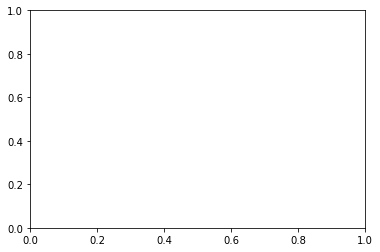

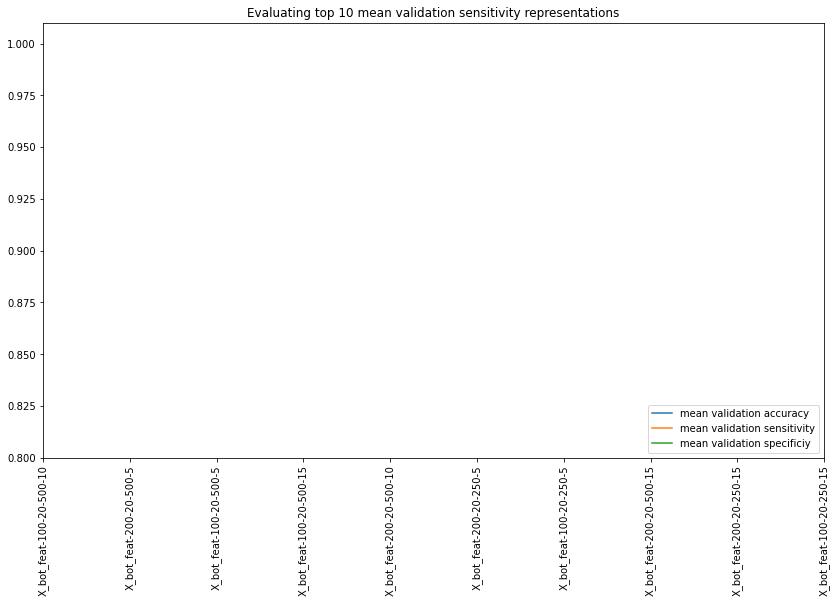

In [99]:
plot_topscores(top_tpr)

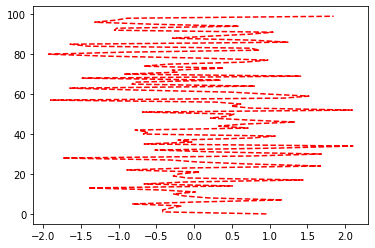

In [107]:
import numpy
from matplotlib import pyplot, transforms

data = numpy.random.randn(100)

# first of all, the base transformation of the data points is needed
base = pyplot.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

# define transformed line
line = pyplot.plot(data, 'r--', transform= rot + base)
# or alternatively, use:
# line.set_transform(rot + base)

pyplot.show()

In [6]:
# get top accuracies
top_tprs = df.sort_values(by=['mean_sensitivity'], ascending=False).iloc[:10,:].copy()

# concatenate representation and mtry for x label
top_tprs['repr_mtry'] = top_tprs.agg(lambda x: f"{x['Representation']} - {x['mtry']}", axis=1)

# normalize seconds to fit in one plot
def normalize(X):
    norm = np.zeros([len(X)])
    for i in range(len(X)):
        norm[i] = (X[i] - min(X)) / (max(X)-min(X))
    return norm

top_tprs['elapsed_norm'] = normalize(np.array(top_tprs['elapsed_seconds']))
top_tprs

,Representation,mean_accuracy,mean_sensitivity,mean_specificity,elapsed_seconds,mtry,repr_mtry,elapsed_norm
47,Cossim on Tfidf,0.9869,0.9342,0.9950,56.5,NaN,Cossim on Tfidf - nan,1.000000
38,Cossim on BoT,0.9882,0.9341,0.9965,14.9,250.0,Cossim on BoT - 250.0,0.151020
39,Cossim on Tfidf,0.9877,0.9322,0.9962,15.7,250.0,Cossim on Tfidf - 250.0,0.167347
31,Cossim on Tfidf,0.9882,0.9322,0.9967,11.4,100.0,Cossim on Tfidf - 100.0,0.079592
23,Cossim on Tfidf,0.9890,0.9303,0.9979,9.2,50.0,Cossim on Tfidf - 50.0,0.034694
46,Cossim on BoT,0.9862,0.9264,0.9953,40.3,NaN,Cossim on BoT - nan,0.669388
30,Cossim on BoT,0.9879,0.9245,0.9976,9.6,100.0,Cossim on BoT - 100.0,0.042857
15,Cossim on Tfidf,0.9872,0.9109,0.9988,7.5,25.0,Cossim on Tfidf - 25.0,0.000000
22,Cossim on BoT,0.9877,0.9109,0.9994,7.9,50.0,Cossim on BoT - 50.0,0.008163
36,BoT + features,0.9841,0.9012,0.9967,19.5,250.0,BoT + features - 250.0,0.244898


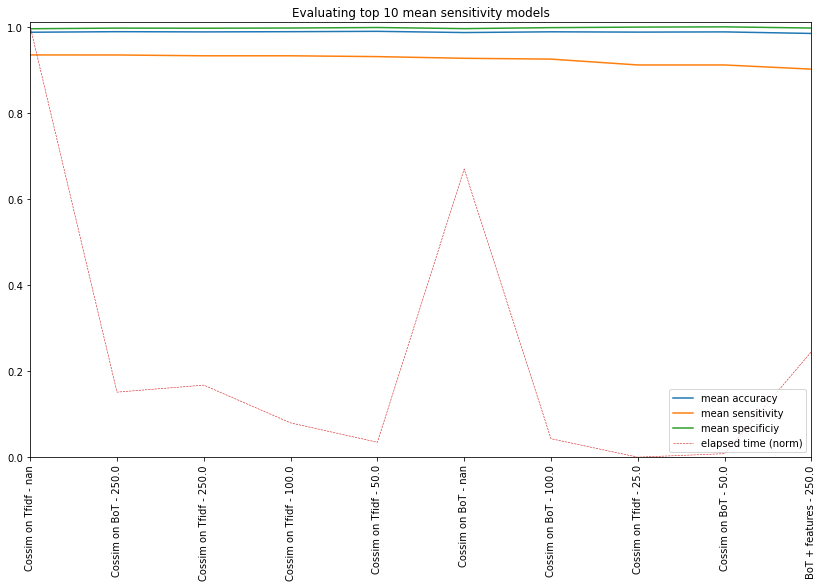

In [9]:
plt.figure(figsize=(14, 8))
plt.plot(np.array(top_tprs['mean_accuracy']), label="mean accuracy")
plt.plot(np.array(top_tprs['mean_sensitivity']), label="mean sensitivity")
plt.plot(np.array(top_tprs['mean_specificity']), label="mean specificiy")
plt.plot(np.array(top_tprs['elapsed_norm']), label='elapsed time (norm)', linewidth=.6, linestyle='dashed')
plt.title('Evaluating top 10 mean sensitivity models')
plt.xticks(np.arange(10), tuple(top_tprs['repr_mtry']))
plt.legend(loc="lower right")
plt.axis([0, 9, 0.0, 1.01])
plt.xticks(rotation=90)
plt.show()

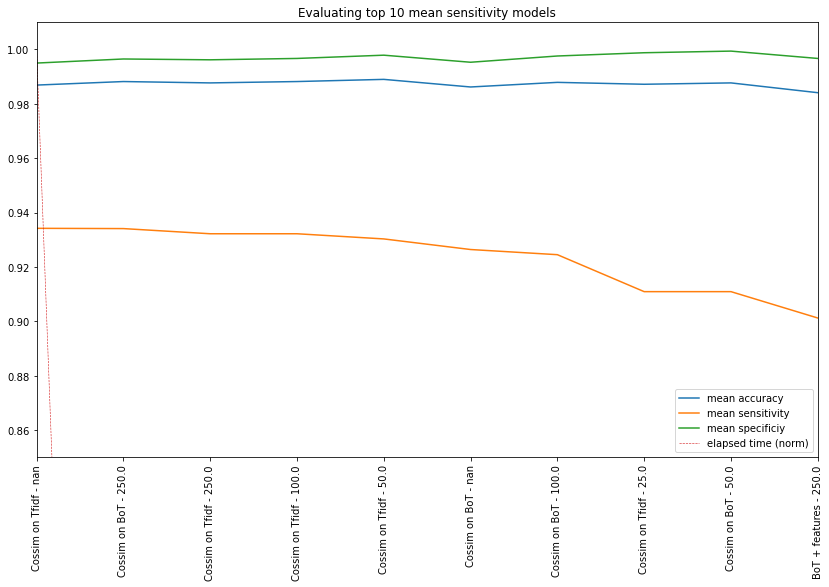

In [10]:
plt.figure(figsize=(14, 8))
plt.plot(np.array(top_tprs['mean_accuracy']), label="mean accuracy")
plt.plot(np.array(top_tprs['mean_sensitivity']), label="mean sensitivity")
plt.plot(np.array(top_tprs['mean_specificity']), label="mean specificiy")
plt.plot(np.array(top_tprs['elapsed_norm']), label='elapsed time (norm)', linewidth=.6, linestyle='dashed')
plt.title('Evaluating top 10 mean sensitivity models')
plt.xticks(np.arange(10), tuple(top_tprs['repr_mtry']))
plt.legend(loc="lower right")
plt.axis([0, 9, 0.85, 1.01])
plt.xticks(rotation=90)
plt.show()

- Cosine similarity models are also the ones with best sensitivities, they win overall
- `mtry=None` is too time consumng for the small gain
- for the small differences in top sensitivities, `Cossim on Tfidf, mtry=50` has the best time (9.2 secs)
- this model and similar ones deserve further attention and more robust cross validation

---